# Analysis of HADA staining in CJW_Bb622
This code encapsulates all the HADA staining single cell analysis for Paddy et al. as found in Figures 1 and S2. 




Code written by Joshua W. McCausland in the CJW lab, 2025.


In the first chunk below, I load the general packages for all analysis here. See comments for annotation.

In [1]:
import numpy as np # numerical functions for general image analysis and plotting
import pandas as pd # dataframe management and excel import
from matplotlib import pyplot as plt,ticker # plotting. Ticker for my modified formatter below.
from lmfit import Model # For fitting gaussian functions.
import glob,os # Directory management
import seaborn as sns # Plotting
from cmcrameri import cm # Scientific colormaps. See https://www.fabiocrameri.ch/colourmaps/
plt.rcParams["font.family"] = "Arial" #Set global font to arial

# two population Gaussian function.
def gaussian_two_pop(x,P,sigma1,mu1,sigma2,mu2):
    y = P*((1/(sigma1 * np.sqrt(2*np.pi)))*np.exp(-0.5 * ((x-mu1)/sigma1)**2)) + (1-P)*((1/(sigma2 * np.sqrt(2*np.pi)))*np.exp(-0.5 * ((x-mu2)/sigma2)**2))
    return y

# one population Gaussian function.
def gaussian(x,sigma,mu):
    y = ((1/(sigma * np.sqrt(2*np.pi)))*np.exp(-0.5 * ((x-mu)/sigma)**2))
    return y

# Some plots span orders of magnitude.
#   - This function reduces the yticks to 1 sig fig for normalized axis spacing.
def y_fmt(x, y, magnitude):
    if x == 0:
        return '0'
    else:
        return f'{(x/magnitude):<2.1f}'.format(x).split('e')[0]

# Custum edit of the ticker class from Matplotlib.
#   - I input my y_fmt function and magnitude (termed scale) of the y axis in __init__
#   - Ticker will automatically format all axes in a loop now based on inputs.
class jwm_FuncFormatter(ticker.Formatter):
    """
    Use a user-defined function for formatting.

    The function should take in two inputs (a tick value ``x`` and a
    position ``pos``), and return a string containing the corresponding
    tick label.
    """

    def __init__(self, func, scale):
        self.func = func
        self.scale = 10**scale # jwm custom variable input. 
        self.offset_string = ""

    def __call__(self, x, pos=None):
        """
        Return the value of the user defined function.

        *x* and *pos* are passed through as-is.
        """
        return self.func(x, pos, self.scale) #include my called scale (magnitude) for the yfmt function above

    def get_offset(self):
        return self.offset_string

    def set_offset_string(self, ofs):
        self.offset_string = ofs


This isn't included in the paper, but as part of the HADA labeling experiment I induced HmgR depletion thorugh CRISPRi for two days before microscopy. I counted my cultures every day to verify the depletion acted as expected through cell density.

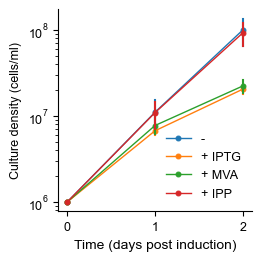

In [50]:
# I include the growth curve data in the "Summary Data" file for reference under the sheet "growth_curve".
gc = pd.read_excel('included_datasets/Summary_Data.xlsx',sheet_name='growth_curve')

# My data labels for the experiment were not the official labels used for the paper. 
# This dictionary redfines the labels for their proper use.
labels = {
    'minus': '-',
    'plus': '+ IPTG',
    'mevalonate': '+ MVA',
    'ipp': '+ IPP'
}

# plot the growth curve
fig,_ax = plt.subplots(figsize = [2.5,2.5],layout = 'constrained')
sns.lineplot(data=gc,x='day',y='density',hue='condition',ax=_ax,errorbar='se',err_style='bars',style='condition',dashes=False,markers=['.','.','.','.'],markersize=7,markeredgecolor=None,linewidth=1)

# to redefine my data labels for the paper, I first extract the current labels from the legend.
handles,labs = _ax.get_legend_handles_labels()

# redefine the labels according to the dictionary.
labs = [labels[lab] for lab in labs]

# Make a legend with the updated labels.
_ax.legend(handles,labs,frameon=False,loc='lower right',fontsize=9)

# Make the plot pretty and add axis labels.
_ax.set_yscale('log')
_ax.tick_params(axis='both',labelsize=9)
_ax.set_ylabel('Culture density (cells/ml)',fontsize=9)
_ax.set_xlabel('Time (days post induction)')
_ax.set_xticks([0,1,2])
_ax.set_yticks([1e6,1e7,1e8])
_ax.spines[['top','right']].set_visible(False)

## Figure 1f. Representative HADA images.
In this panel, I take representative cells from the HADA experiment and plot them with their fluorescence scaled to one another. Plotting these images and drawing cell outlines requires additional packages and custom functions, based on my code from our previous publication (PMID 40623106).

In [2]:
# relevant imaging packages. 
# Binary fill holes will fill gaps in the cell masks
# binary dilation will be useful for drawing cell contours
from scipy.ndimage import binary_fill_holes,binary_dilation

# labeling will allow me to identify objects in the binary mask.
from skimage.measure import label

# clear border will clear masks that touch the edge of the image. 
from skimage.segmentation import clear_border

# read the image files
from skimage.io import imread

# a rough Otsu threshold will help with background subtraction.
from skimage.filters import threshold_otsu

# use cv2 for its suite of image analysis functions.
import cv2

# this helps identify the coordinates for the segmented cell.
def get_indices_pandas(data):
    d = data.ravel()
    f = lambda x: np.unravel_index(x.index, data.shape)
    return pd.Series(d).groupby(d).apply(f)

# Feed the phase contrast image to this function, and it returns the contour (boundary of the cell)
#   - Smooth the image with a median filter, then use the adaptive threshold from cv2 to binarize it. 
#   - fill holes/aberrations if any exist in the mask. 
#   - label all objects in the binarized images. 
#   - Remove objects touching the boundary of the image (cells that are cropped)
#   - dilate the binary object (cell) several times to make it bigger than the original. This helps when making the contour. 
#   - Grab the coordinates of this mask, then find the contour. 
def adaptive_threshold_contours(img,footprint = 7):
    # Find the image width and height.
    sensor = img.shape

    # cv2 works in the 8 bit range, so normalize the image to 255 bits
    img = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

    # Apply a median blur to help with thresholding.
    img = cv2.medianBlur(img,9)

    # Run an adaptive threshold 
    bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,footprint,3)

    # Fill obvious holes from the threhold.
    bw = binary_fill_holes(np.invert(bw))

    # Convert the binary image to 0/1
    bw = bw.astype('int')

    # Label all identified objects in the binary image.
    ccs = label(bw)

    # Determine the sizes of the objects
    component_sizes = np.bincount(ccs.ravel())

    # Identify objects less than 500 square pixels.
    too_small = component_sizes < 500
    too_small_mask = too_small[ccs]

    # Remove the small objects.
    ccs[too_small_mask] = 0

    # If cell objects touch the border, remove them.
    ccs = clear_border(ccs,buffer_size = 5)

    # Dilate the object 5 times for contour drawing.
    ccs = binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(ccs)))))

    # One final obejct identification with the final mask
    ccs = label(ccs)

    # Empty cell contour list to append to.
    cell_contours = []

    # Get the indices for the cell object using the function above.
    cell_coords = get_indices_pandas(ccs)

    # Now trace the contour of the binary object using the cell coordinates.
    for cell_coord in cell_coords:
        # Make a temporary mask with the size of the image.
        temp_mask = np.full(sensor,fill_value=0)

        # Draw the cell coordinates as the max bit value.
        temp_mask[cell_coord[0],cell_coord[1]] = 255

        # Find the contour of the cell
        contours,_ = cv2.findContours(temp_mask.astype('uint8'),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Append the contours to the list.
        cell_contours.append(np.vstack(np.vstack(contours)))
    return cell_contours


# This estimates the mean background signal and subtracts it from the image. 
#   - Take an Otsu threshold of the image and identify cellular objects roughly.
#   - Pull coordinates of all image pixels outside of the cellular object (the background).
#   - Find the mean signal of those background pixels.
#   - To account for potentiall negative pixels, add the absolute value of the min pixel value
def subtract_background(images):
    # Separate out the phase and fluorescent images from input
    phase = images['phase']
    fluor = images['fluor']

    # Find the width and height of the phase image.
    sensor = phase.shape

    # Determine the Otsu threshold from the phase image.
    thresh = threshold_otsu(phase)

    # Create a binary image of 0/1 based on the threshold.
    bw = 1*(phase < thresh)
    bw = bw.astype('int')

    # As above, label binary objects and remove the small ones less than 500 square pixels.
    ccs = label(bw)
    component_sizes = np.bincount(ccs.ravel())
    too_small = component_sizes < 500
    too_small_mask = too_small[ccs]
    ccs[too_small_mask] = 0

    # Remove objects touching the border
    ccs = clear_border(ccs,buffer_size = 5)

    # Give wide clearance to the identified objects in case their fluorescence spans outside the cell boundary.
    ccs = binary_dilation(binary_dilation(binary_dilation(ccs)))

    # Relabel the final objects
    ccs = label(ccs)

    # Obtain the object coordinates.
    cell_coords = get_indices_pandas(ccs)

    # In our case, we only need the first object. Representative images have only one cell.
    cell_coords = cell_coords.iloc[0]

    # Create a blank image of 0s in the shape of the input image.
    background_matrix = np.zeros(shape=sensor)

    # Populate the image with 1s in the background spots
    background_matrix[cell_coords[0],cell_coords[1]] = 1

    # Convert the 1s to TRUE.
    background_matrix = background_matrix.astype('bool')

    # Grab all background values by taking TRUE pixels from fluorescence and determining their mean. Subtract the mean from the base fluorescent image.
    bkg_sbt = fluor - fluor[background_matrix].mean()

    # Add the absolute value of the minimum background subtracted pixel to bring the minimum pixel value to 0.
    bkg_sbt = bkg_sbt + abs(bkg_sbt.min())
    return bkg_sbt

Now that we have defined our functions, here I plot the representaive cells in phase and fluroescence. Use the phase contrast images to draw contours around the fluorescent signal to demonstrate where the signal is localized.

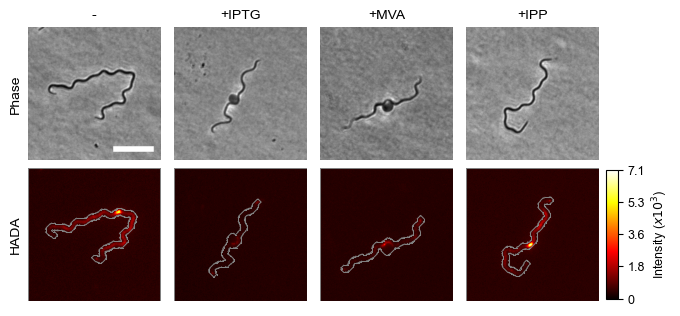

In [4]:
###################################################################################################
# Size of the scale bar
scale_bar_size = 5 #answer in microns

# Calculates the pixel distance for the desired scale bar size.
px_for_scale_bar = scale_bar_size/0.065 #divide the scale bar size by the pixel size

# Diectory for the HADA representative images.
hada_image_files = glob.glob('included_datasets/representative_HADA_images/*.tif')
####################################################################################################

# Create a dictionary of HADA images to reference. 
hada_images = {}

# Iterate through each image file and add them to the dictionary.
for image_file in hada_image_files:
    fname = fname = os.path.basename(image_file).removesuffix('.tif') # Find file name.
    hada_images[fname] = {} # Create an empty dictionary for the current filename. This will be populated with all the components of the image.
    temp_im = imread(image_file) # Read the image file.
    hada_images[fname]['phase'] = temp_im[0] # archive the phase image.
    hada_images[fname]['fluor'] = temp_im[1] # archive the fluorescent image.
    hada_images[fname]['contour'] = adaptive_threshold_contours(temp_im[0],footprint=11) # Determine the contour of the phase image.
    hada_images[fname]['bkg_sbt'] = subtract_background(hada_images[fname]) # measure the background of the current image.

# Order to plot the images.
image_order = ['minus_iptg','plus_iptg','plus_mva','plus_ipp']

# Re order the dictionary for my specified image order.
hada_images = {key: hada_images[key] for key in image_order}

# Determine the max fluorescent and phase pixel values for plotting. 
max_fluor = np.max(np.concatenate([hada_images[key]['bkg_sbt'] for key in hada_images]))
max_phase = np.max(np.concatenate([hada_images[key]['phase'] for key in hada_images]))

# plot the phase and fluorescent images.
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=[6,3],layout='constrained')
for ax_col,dict_items in zip(axs.T,hada_images.items()):
    key,val = dict_items
    
    # Plot the phase.
    ax_col[0].imshow(val['phase'],cmap='gray')

    # Plot the flurorescent image. Save this as "cax" for colorbar plotting.
    #   - Use the scientific colormaps package, cmcrameri, for colorblind-friendly scale.
    #   - minimum pixel value is 0 and maximum is the max_fluor determined above.
    cax = ax_col[1].imshow(val['bkg_sbt'],cmap='hot',vmin=0,vmax=max_fluor)

    # Add a contour to the fluorescent image.
    #   - Loop through the contour and plot it one step at a time. 
    for _contour in val['contour']:
        for idx in np.arange(len(_contour)+1):
            if idx < len(_contour):
                step = np.column_stack([_contour[idx-1],_contour[idx]])
                ax_col[1].plot(step[0],step[1],'-',color='gray',linewidth=0.75)

#scale bar
axs[0,0].plot([200,200+px_for_scale_bar],[275,275],'-',color='white',linewidth=4)

# now add colorbars for intensity scaling context. 
width_height = [0.02,0.43]
cbar_ax1 = fig.add_axes([1,0.022]+width_height)
cbar = fig.colorbar(cax, cax=cbar_ax1,orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_yticks(np.linspace(0,max_fluor,5))

# I determine the scale of the intensity values and apply that to my jwm_FuncFormatter function defined in the preamble.
scale = int(np.floor(np.log10(max_fluor)))
cbar.ax.set_ylabel(('Intensity ($x10^{{{}}}$)').format(scale),fontsize=9)
cbar.ax.yaxis.set_major_formatter(jwm_FuncFormatter(y_fmt,scale))

# Since these are images, remove all graph lines and ticks.
for ax in axs.ravel():
    ax.spines[['top','right','left','bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0,0].set_title('-',fontsize=10)
axs[0,0].set_ylabel('Phase',fontsize=10)
axs[0,1].set_title('+IPTG',fontsize=10)
axs[0,2].set_title('+MVA', fontsize=10)
axs[0,3].set_title('+IPP', fontsize=10)
axs[1,0].set_ylabel('HADA',fontsize=10)
plt.savefig('plots/hada_rep_images.png',dpi=600,bbox_inches='tight')
plt.savefig('plots/hada_rep_images.pdf',bbox_inches='tight')

## Figure 1g-j: Histograms of single cell HADA intensity.
In this section, I will plot the four histograms for each of the single cell distributions of HADA intensity. 
- Importantly, the bins are calculated from all data pooled together so each distribution shares the same bin space. This makes them comparable.
- I fit them to a two population Gaussian distribution for a total fit, then I plot single Gaussian distributions from the two pop fit results.

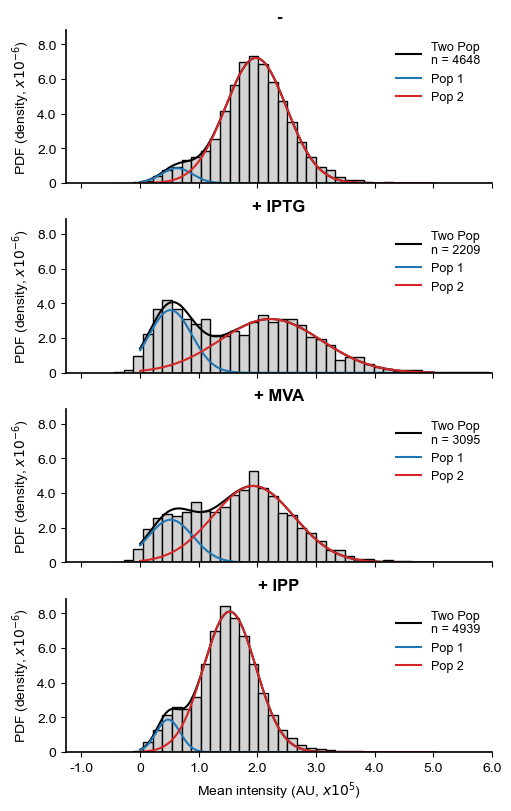

In [31]:
# Load the included pooled single cell data.
pooled_df = pd.read_excel('included_datasets/single_cell_data.xlsx')

# Make a dictionary to define the conditions by the paper's conventions.
labels = {
    'Minus_IPTG': '-',
    'Plus_IPTG': '+ IPTG',
    'Plus_Mevalonate': '+ MVA',
    'Plus_IPP': '+ IPP'
}

# Create a model based on the two population Gaussian
gmodel = Model(gaussian_two_pop)

# Input starting guesses for the fit.
gmodel.set_param_hint('P',min=0,max=1)
gmodel.set_param_hint('sigma1',min=1e3)
gmodel.set_param_hint('sigma2',min=1e3)
gmodel.set_param_hint('mu1',min=5e3,max=7e4)
gmodel.set_param_hint('mu2',min=1e4,max=3e5)

# Create an empty dataframe to populate with fit parameters.
params = pd.DataFrame()
# the linear space for the xfit.
xfit = np.linspace(0,5e5,1000)

# create the figure
fig,axs = plt.subplots(nrows=4,figsize = [5,8],layout = 'constrained',sharex=True,sharey=True)

# Determine the 100 bins for ALL pooled data. These will be applied to each condition.
_,bins = np.histogram(pooled_df.Norm_Intens_Area,100)

# Sort the conditions by a specified order for the paper.
pooled_df = pooled_df.sort_values('condition', key = lambda s: s.apply(['Minus_IPTG','Plus_IPTG','Plus_Mevalonate','Plus_IPP'].index))

# Iterate through the conditions and plot their distributions.
for _ax,grouped in zip(axs,pooled_df.groupby('condition',sort=False)):
    key,grp = grouped # extract the condition (key) and its dataframe (grp)

    # plot the histogram with the specified bins
    h = _ax.hist(grp.Norm_Intens_Area,bins,density=True,edgecolor='black',facecolor='lightgray')

    # Determine the center of each bin for fitting. 
    bin_centers = h[1] + np.diff(h[1])[0]/2

    # Fit the bin centers with their heights for the two population Gaussian
    result = gmodel.fit(h[0].ravel(),x=bin_centers[:-1].ravel(),P=0.5,mu1=1e3,sigma1=1e4,mu2=5e4,sigma2=1e5)

    # Extract the fit parameters as a temporary dataframe
    params_temp = pd.DataFrame(result.params.valuesdict(),index = [key])

    # store the fit parameters into the params dataframe.
    params = pd.concat([params,params_temp])

    # Find the theoretical two pop fit values from the parameters and linear xfit. Plot xfit and yfit.
    yfit = gaussian_two_pop(xfit,params_temp['P'].values,params_temp['sigma1'].values,params_temp['mu1'].values,params_temp['sigma2'].values,params_temp['mu2'].values)
    _ax.plot(xfit,yfit,'-',color = 'black',label = f'Two Pop\nn = {grp.shape[0]}')

    # Find the theoretical first pop fit values from the parameters and linear xfit. Plot xfit and yfit.
    label = f'Pop 1\n$\mu_1$ = {params.loc[key].mu1:.2e}'
    yfit_1 = gaussian(xfit,params_temp['sigma1'].values,params_temp['mu1'].values) * params_temp['P'].values
    _ax.plot(xfit,yfit_1,'-',color = 'tab:blue',label = 'Pop 1')

    # Find the theoretical second pop fit values from the parameters and linear xfit. Plot xfit and yfit.
    label = f'Pop 2\n$\mu_2$ = {params.loc[key].mu2:.2e}'
    yfit_2 = gaussian(xfit,params_temp['sigma2'].values,params_temp['mu2'].values) * (1-params_temp['P'].values)
    _ax.plot(xfit,yfit_2,'-',color = 'tab:red',label = 'Pop 2')

    # Find the y axis scale and format it according to my custum ticker function.
    max_num = yfit.max()
    yscale = int(np.floor(np.log10(max_num)))
    _ax.yaxis.set_major_formatter(jwm_FuncFormatter(y_fmt,yscale))
    _ax.set_ylabel(('PDF (density, $x10^{{{}}}$)').format(yscale),fontsize=10)

    # make the plot pretty.
    _ax.legend(frameon=False,fontsize=9,loc = 'upper right')
    _ax.set_title(labels[key],weight = 'bold')
    _ax.spines[['top','right']].set_visible(False)
    _ax.spines[['bottom','left']].set_linewidth(1.2)
    _ax.set_xlim(right = 6e5)

# Now apply the custum ticker formatter to the final x axis.
xlims = _ax.get_xlim()
xscale = int(np.floor(np.log10(max(xlims))))
_ax.xaxis.set_major_formatter(jwm_FuncFormatter(y_fmt,xscale))
_ax.set_xlabel(('Mean intensity (AU, $x10^{{{}}}$)').format(xscale),fontsize=10)

# save the plot
plt.savefig('plots/hada_dist.png',dpi=600)
plt.savefig('plots/hada_dist.pdf')

## Figure S3: Individual single cell intensity distributions
This applies the same code from above, but now splits the histograms into individual biological replicates.

,P,mu1,sigma1,mu2,sigma2
Minus_IPTG-1,0.062597,69978.338986,204943.239145,213707.308930,51052.569789
Plus_IPTG-1,0.506381,49590.747984,40278.774298,200545.474277,101423.816543
Plus_Mevalonate-1,0.303938,55442.744382,39546.140987,184999.855435,81520.530578
Plus_IPP-1,0.041486,60366.666512,18321.271249,181148.558554,43304.520901
Minus_IPTG-2,0.118874,69355.469136,27293.466634,185396.541746,41926.431887
Plus_IPTG-2,0.326883,50524.866581,33571.650865,237692.971939,87892.814941
Plus_Mevalonate-2,0.265372,49149.088002,38537.353150,205537.136381,77275.378001
Plus_IPP-2,0.117078,43352.307588,22654.799428,144038.950410,39951.258415
Minus_IPTG-3,0.031340,60142.173406,26174.612924,203320.912553,61424.858392
Plus_IPTG-3,0.216249,69999.913839,32251.343369,219861.811630,69976.030363


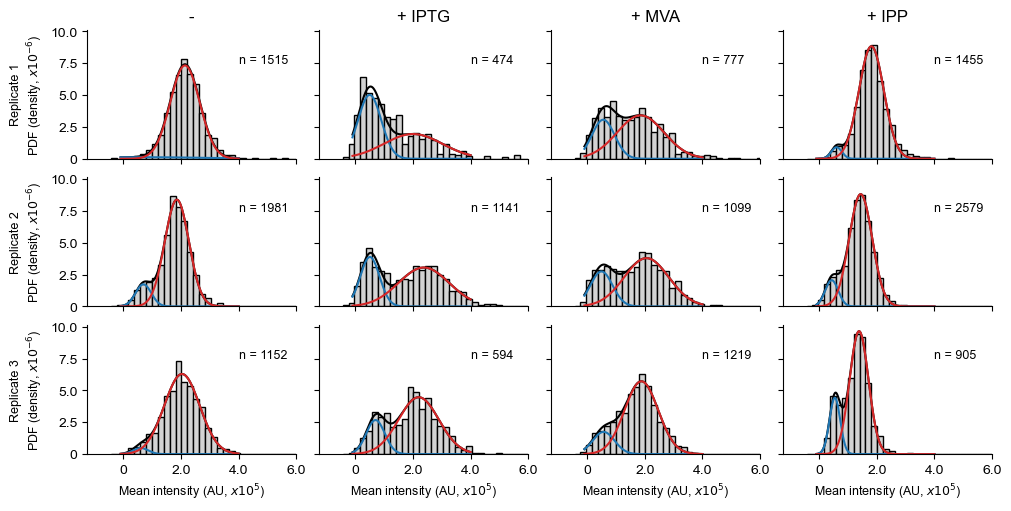

In [32]:
pooled_df = pd.read_excel('included_datasets/single_cell_data.xlsx')

labels = {
    'Minus_IPTG': '-',
    'Plus_IPTG': '+ IPTG',
    'Plus_Mevalonate': '+ MVA',
    'Plus_IPP': '+ IPP'
}

gmodel = Model(gaussian_two_pop)
gmodel.set_param_hint('P',min=0,max=1)
gmodel.set_param_hint('sigma1',min=5e3)
gmodel.set_param_hint('sigma2',min=1e3)
gmodel.set_param_hint('mu1',min=1.5e4,max=7e4)
conditions = ['Minus_IPTG','Plus_IPTG','Plus_Mevalonate','Plus_IPP']
params = pd.DataFrame()

fig,axs = plt.subplots(nrows=3,ncols=4,figsize = [10,5],layout = 'constrained',sharex=True,sharey=True)
_,bins = np.histogram(pooled_df.Norm_Intens_Area,80)
replicate_counter = 1
for ax_row in axs:
    for idx,condition in enumerate(conditions):
        grp = pooled_df[(pooled_df.condition == condition) & (pooled_df.replicate == replicate_counter)]
        _ax = ax_row[idx]
        h = _ax.hist(grp.Norm_Intens_Area,bins,density=True,edgecolor='black',facecolor='lightgray')
        bin_centers = h[1] + np.diff(h[1])[0]/2

        # Minus IPTG replicate 1 has a strong single population. The fit params have to be adjusted for this otherwise the fit is off.
        if (replicate_counter == 1) and (condition == 'Plus_IPTG'):
            gmodel.set_param_hint('mu2',min=2e5,max=3e5)
            result = gmodel.fit(h[0].ravel(),x=bin_centers[:-1].ravel(),P=0.5,mu1=1e4,sigma1=3e4,mu2=2e5,sigma2=1e5)
        else:
            gmodel.set_param_hint('mu2',min=1e4,max=3e5)
            result = gmodel.fit(h[0].ravel(),x=bin_centers[:-1].ravel(),P=0.5,mu1=1e4,sigma1=1e4,mu2=5e4,sigma2=1e5)
        params_temp = pd.DataFrame(result.params.valuesdict(),index = [f'{condition}-{replicate_counter}'])
        xfit = np.linspace(-1e4,4e5,1000)
        
        yfit = gaussian_two_pop(xfit,params_temp.P.values,params_temp.sigma1.values,params_temp.mu1.values,params_temp.sigma2.values,params_temp.mu2.values)
        _ax.plot(xfit,yfit,'-',color = 'black',label = f'Two Pop\nn = {grp.shape[0]}')
        
        yfit_1 = gaussian(xfit,params_temp['sigma1'].values,params_temp['mu1'].values) * params_temp['P'].values
        _ax.plot(xfit,yfit_1,'-',color = 'tab:blue',label = 'Pop 1')

        yfit_2 = gaussian(xfit,params_temp['sigma2'].values,params_temp['mu2'].values) * (1-params_temp['P'].values)
        _ax.plot(xfit,yfit_2,'-',color = 'tab:red',label = 'Pop 2')

        params = pd.concat([params,params_temp])
        _ax.spines[['top','right']].set_visible(False)
        _ax.set_xlim(right=6e5)
        _ax.text(0.4e6,7.5e-6,f'n = {grp[grp.replicate == replicate_counter].shape[0]}',fontsize=9)
        
        if replicate_counter == 1:
            _title = labels[condition]
            _ax.set_title(_title)
        if idx == 0:
            max_num = yfit.max()
            yscale = int(np.floor(np.log10(max_num)))
            _ax.yaxis.set_major_formatter(jwm_FuncFormatter(y_fmt,yscale))
            _ax.set_ylabel(('Replicate {}\nPDF (density, $x10^{{{}}}$)').format(replicate_counter,yscale),fontsize=9)
        if replicate_counter == 3:
            xlims = _ax.get_xlim()
            xscale = int(np.floor(np.log10(max(xlims))))
            _ax.xaxis.set_major_formatter(jwm_FuncFormatter(y_fmt,xscale))
            _ax.set_xlabel(('Mean intensity (AU, $x10^{{{}}}$)').format(xscale),fontsize=9)

    replicate_counter += 1
_ax.set_yticks(np.array([0,2.5,5,7.5,10])*1e-6)
plt.savefig('plots/hada_ind_reps.png',dpi=600)
plt.savefig('plots/hada_ind_reps.pdf')
params[['P','mu1','sigma1','mu2','sigma2']]